In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

### format plotting
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False


subs = [0,1,2,3,4]
beh_data = []
for sub in subs: 
    base_path = "/projects/crunchie/boyanova/EEG_Things/Mask_ExpAtt_EEG/beh/pilot"
    sub_folder = os.path.join(base_path, f"sub-{sub:04}") 
    beh_files = os.listdir(sub_folder)


    for bh in beh_files:
        beh_data.append(pd.read_csv(os.path.join(sub_folder, bh)))
    
beh_data = pd.concat(beh_data).reset_index(drop=True)

# substitute all None with np.nan
beh_data = beh_data.replace(["None", "none", ""], np.nan)

# convert boolean accuracy to numeric
beh_data["correct_loc"] = beh_data["correct_loc"].astype(float)
beh_data["correct_id"]  = beh_data["correct_id"].astype(float)

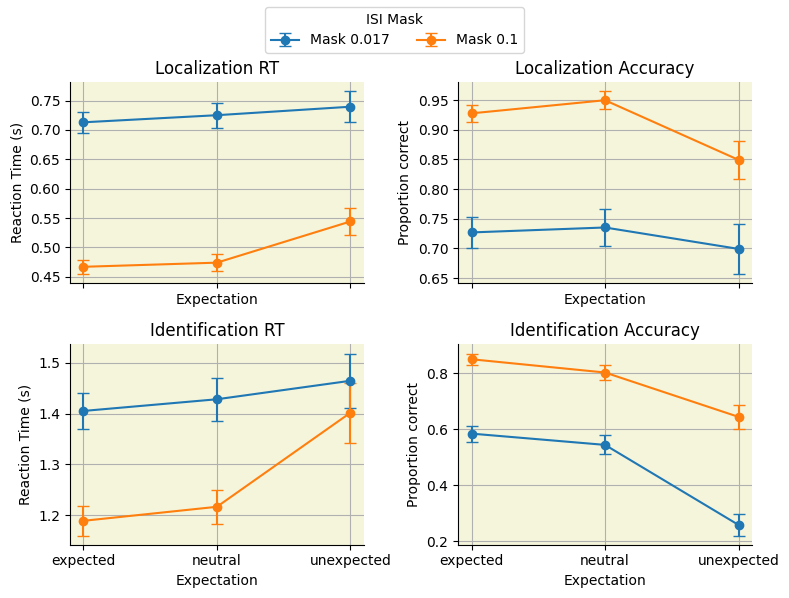

In [13]:

def plot_interaction(ax, df, dv, ylabel):
    expectations = sorted(df["expectation"].unique())
    masks = sorted(df["isi_mask"].unique())

    x = np.arange(len(expectations))
    lines = []

    for mask in masks:
        subset = df[df["isi_mask"] == mask]

        means = subset.groupby("expectation")[dv].mean().reindex(expectations)
        ses = subset.groupby("expectation")[dv].sem().reindex(expectations)

        line = ax.errorbar(
            x,
            means,
            yerr=ses,
            marker="o",
            capsize=4,
            label=f"Mask {mask}"
        )
        lines.append(line)

    ax.set_xticks(x)
    ax.set_xticklabels(expectations)
    ax.set_xlabel("Expectation")
    ax.set_ylabel(ylabel)
    ax.patch.set_facecolor("#f5f5dc")

    return lines


fig, axes = plt.subplots(2, 2, figsize=(8,6), sharex=True)

# --- Localization ---
lines = plot_interaction(axes[0,0], beh_data, "rt_loc", "Reaction Time (s)")
axes[0,0].set_title("Localization RT")
axes[0,0].grid("--")

plot_interaction(axes[0,1], beh_data, "correct_loc", "Proportion correct")
axes[0,1].set_title("Localization Accuracy")
axes[0,1].grid("--")

# --- Identification ---
plot_interaction(axes[1,0], beh_data, "rt_id", "Reaction Time (s)")
axes[1,0].set_title("Identification RT")
axes[1,0].grid("--")

plot_interaction(axes[1,1], beh_data, "correct_id", "Proportion correct")
axes[1,1].set_title("Identification Accuracy")
axes[1,1].grid("--")


labels = [l.get_label() for l in lines]

fig.legend(
    lines,
    labels,
    title="ISI Mask",
    loc="upper center",
    ncol=len(labels)
)

plt.tight_layout(rect=[0,0,1,0.93])  # leave space for legend
plt.show()



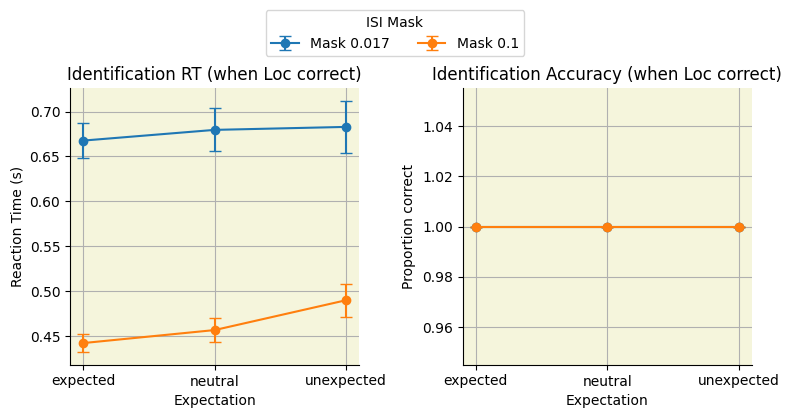

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(8,4), sharex=True)

loc_correct = beh_data[beh_data.correct_loc == 1].reset_index(drop=True)
# --- Identification  ---
lines = plot_interaction(axes[0], loc_correct, "rt_loc", "Reaction Time (s)")
axes[0].set_title("Identification RT (when Loc correct)")
axes[0].grid("--")

plot_interaction(axes[1], loc_correct, "correct_loc", "Proportion correct")
axes[1].set_title("Identification Accuracy (when Loc correct)")
axes[1].grid("--")

labels = [l.get_label() for l in lines]

fig.legend(
    lines,
    labels,
    title="ISI Mask",
    loc="upper center",
    ncol=len(labels),
    bbox_to_anchor=(0.5, 1.05)
)

plt.tight_layout(rect=[0,0,1,0.93])  # leave space for legend
plt.show()

In [20]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model_rt = ols(
    "correct_loc ~ C(isi_mask) * C(expectation)",
    data=beh_data
).fit()

anova_rt = sm.stats.anova_lm(model_rt, typ=2)
anova_rt["PR(>F)"] = anova_rt["PR(>F)"].round(3)
print("\nRT ANOVA (location)")
print(anova_rt)


RT ANOVA (location)
                                sum_sq      df          F  PR(>F)
C(isi_mask)                  12.096446     1.0  89.488834   0.000
C(expectation)                0.776826     2.0   2.873457   0.057
C(isi_mask):C(expectation)    0.170760     2.0   0.631635   0.532
Residual                    170.723102  1263.0        NaN     NaN


In [34]:
def facet_pointplot(
    df,
    dv,
    facet_col="taget_name",
    x_col="expectation",
    hue_col="isi_mask",
    ylabel=None,
    ylim=None,
    title=None
):
    targets = sorted(df[facet_col].unique())
    expectations = sorted(df[x_col].unique())
    hues = sorted(df[hue_col].unique())

    fig, axes = plt.subplots(
        1,
        len(targets),
        figsize=(4*len(targets),4)
    )

    if len(targets) == 1:
        axes = [axes]

    x = np.arange(len(expectations))
    legend_lines = None

    for ax, target in zip(axes, targets):

        df_t = df[df[facet_col] == target]
        lines = []

        for h in hues:
            sub = df_t[df_t[hue_col] == h]

            means = sub.groupby(x_col)[dv].mean().reindex(expectations)
            ses = sub.groupby(x_col)[dv].sem().reindex(expectations)

            line = ax.errorbar(
                x,
                means,
                yerr=ses,
                marker="o",
                capsize=4,
                label=f"{hue_col} {h}"
            )
            lines.append(line)

        ax.set_title(str(target))
        ax.set_xticks(x)
        ax.set_xticklabels(expectations)
        ax.set_xlabel(x_col)
        ax.patch.set_facecolor("#f5f5dc")

        if ax is axes[0]:
            ax.set_ylabel(ylabel if ylabel else dv)

        if ylim:
            ax.set_ylim(ylim)

        ax.grid("--")

        if legend_lines is None:
            legend_lines = lines
        
        if title:
            fig.suptitle(title, fontsize=14)

    plt.tight_layout(rect=[0,0,1,0.9])
    plt.show()

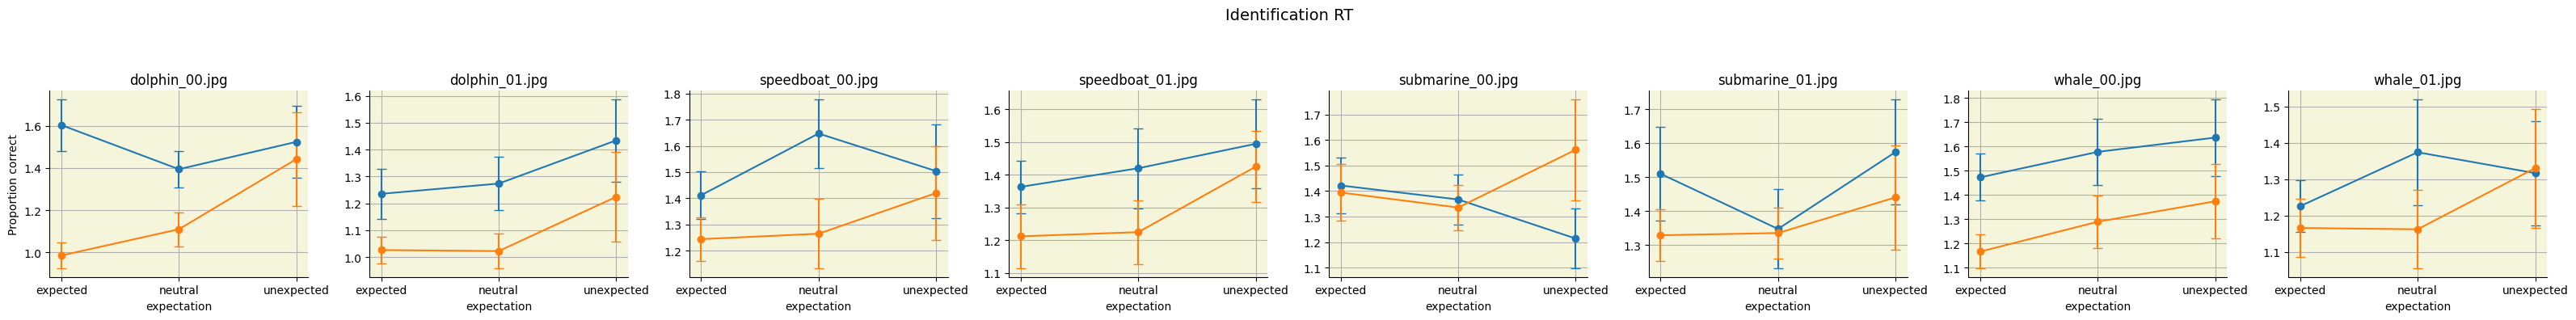

In [41]:
facet_pointplot(
    beh_data,
    "rt_id",
    ylabel="Proportion correct",
    title="Identification RT"
)

